In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import random
import rl_utils

In [36]:
## Q-net with only one hidden layer
class Q_net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Q_net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
## P-net with only one hidden layer
class P_net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(P_net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1) # "dim=1" to be detailed, may be related to action space

In [37]:
class AC_basic:
    def __init__(self, state_dim, hidden_dim, action_dim, gamma=0.98, actor_lr=1e-3, critic_lr=1e-2, device = "cpu"):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.device = device
        
        # Initialize Q and P networks
        self.Q_net = Q_net(state_dim, hidden_dim, action_dim).to(self.device)
        self.P_net = P_net(state_dim, hidden_dim, action_dim).to(self.device)
        
        # Optimizers for Q and P networks
        self.Q_optimizer = torch.optim.Adam(self.Q_net.parameters(), lr=critic_lr)
        self.P_optimizer = torch.optim.Adam(self.P_net.parameters(), lr=actor_lr)
        
    def action_selection(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action_prob = self.P_net(state)
        action_dist = torch.distributions.Categorical(action_prob)
        action = action_dist.sample()
        return action.item()
    
    def AC_update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        # next_actions = torch.concatenate((actions[1:,:], actions[-1,:].unsqueeze(1)), dim=0)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).unsqueeze(1).view(-1, 1).to(self.device)
        discount_gamma = torch.tensor([self.gamma ** i for i in range(len(rewards))], dtype=torch.float).view(-1, 1).to(self.device)
        
        Q_values = self.Q_net(states).max(1)[0].view(-1, 1)  # 当前状态和动作的价值
        Q_target = rewards + self.gamma * self.Q_net(next_states).max(1)[0].view(-1, 1) * (1 - dones)
        Q_delta = Q_target - Q_values  # 时序差分误差
        ln_probs = torch.log(self.P_net(states).gather(1, actions))
        P_loss = torch.mean(-discount_gamma * ln_probs * Q_delta.detach())
        Q_loss = F.mse_loss(Q_values, Q_target)
        self.P_optimizer.zero_grad()
        self.Q_optimizer.zero_grad()
        P_loss.backward()
        Q_loss.backward()
        # for name, param in self.Q_net.named_parameters():
        #     if param.grad is not None:
        #         print(name, param.grad.norm())

        self.P_optimizer.step()
        self.Q_optimizer.step()
    
        

In [38]:
## AC Main Program
actor_lr = 1e-3
critic_lr = 1e-2
hidden_dim = 200 # hidden layer dimension
gamma = 0.98 # discount factor
# epsilon = 0.05 # exploration rate
num_episodes = 1000 # number of episodes to train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1') # 'CartPole-v1' is a classic control task, can be changed to other environments

# C.I.A.L.L.O. random seed
env.action_space.seed(1)
torch.manual_seed(1)

state_dim = env.observation_space.shape[0] # default dim = 4, position, velocity, angle, angular velocity
action_dim = env.action_space.n # default dim = 2 (Bang-Bang control), can be changed to 3 or more
agent = AC_basic(state_dim, hidden_dim, action_dim, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr, device=device)

# Main online loop
return_list = []
for i in range(10):
    for i_ep in range(int(num_episodes/10)):
        # reset environment and transition dictionary
        episode_return = 0
        state, _ = env.reset()
        transition_dict = {'states': [], 'actions': [], 'rewards': [], 'next_states': [], 'dones': []} # S.A.R.S.D.
        done = False
        # Simulate one episode
        while not done:
            # step forward
            action = agent.action_selection(state)
            next_state, reward, done, _, _ = env.step(action)
            # store the transition in the transition dictionary
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['rewards'].append(reward)
            transition_dict['next_states'].append(next_state)
            transition_dict['dones'].append(done)
            state = next_state # update state
            episode_return += reward # record the return
            
        # update the agent
        agent.AC_update(transition_dict)
        return_list.append(episode_return)
        # print the return of the episode every 10 episodes
        if (i_ep + 1) % 10 == 0:
            print(f'Episode {i * int(num_episodes/10) + i_ep + 1}, Return: {episode_return}, Length: {len(transition_dict["states"])}')

Episode 10, Return: 22.0, Length: 22
Episode 20, Return: 35.0, Length: 35
Episode 30, Return: 25.0, Length: 25
Episode 40, Return: 37.0, Length: 37
Episode 50, Return: 11.0, Length: 11
Episode 60, Return: 44.0, Length: 44
Episode 70, Return: 15.0, Length: 15
Episode 80, Return: 40.0, Length: 40
Episode 90, Return: 92.0, Length: 92
Episode 100, Return: 54.0, Length: 54
Episode 110, Return: 24.0, Length: 24
Episode 120, Return: 61.0, Length: 61
Episode 130, Return: 27.0, Length: 27
Episode 140, Return: 25.0, Length: 25
Episode 150, Return: 56.0, Length: 56
Episode 160, Return: 30.0, Length: 30
Episode 170, Return: 20.0, Length: 20
Episode 180, Return: 32.0, Length: 32
Episode 190, Return: 51.0, Length: 51
Episode 200, Return: 48.0, Length: 48
Episode 210, Return: 32.0, Length: 32
Episode 220, Return: 20.0, Length: 20
Episode 230, Return: 31.0, Length: 31
Episode 240, Return: 33.0, Length: 33
Episode 250, Return: 49.0, Length: 49
Episode 260, Return: 87.0, Length: 87
Episode 270, Return: 

In [39]:
## human play
def human_play(env, agent):
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.action_selection(state)
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
    env.close()
    
env = gym.make('CartPole-v1', render_mode='human')  # Render mode for human play
human_play(env, agent)

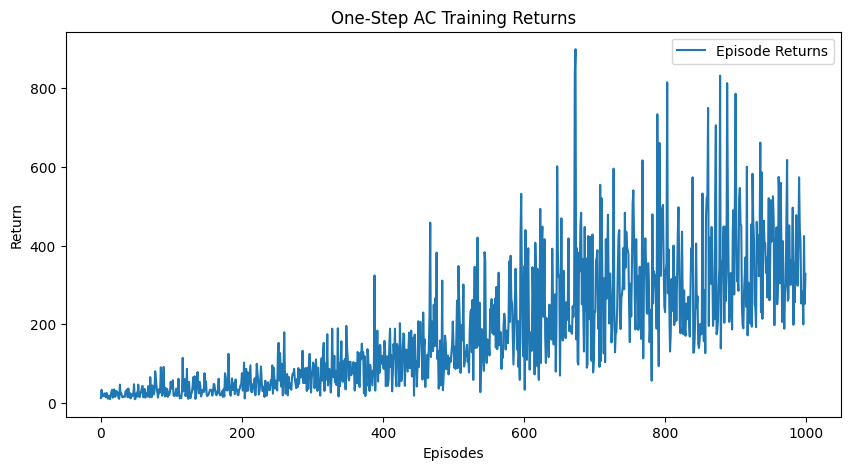

In [41]:
## Plotting the results
episodes_list = list(range(len(return_list)))
plt.figure(figsize=(10, 5))
plt.plot(episodes_list, return_list, label='Episode Returns')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('One-Step AC Training Returns')
plt.legend()


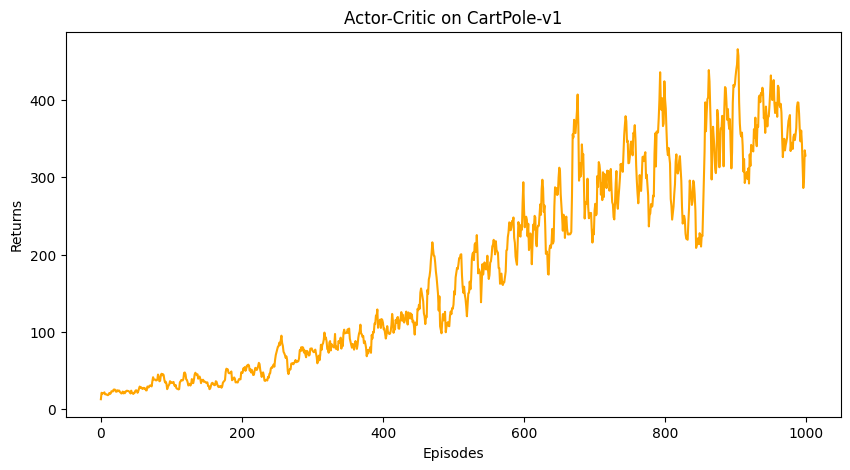

In [43]:
# move average return list to be added
plt.figure(figsize=(10, 5))
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return, color='orange', label='Moving Average Return')
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format('CartPole-v1'))
plt.show()